In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate, RepeatedKFold, KFold
from sklearn.metrics import mean_squared_error, r2_score
from flaml import AutoML
import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Monday: 1 ; Tuesday: 2 ; Wednesday: 3 ; Thursday: 4 ; Friday: 5 ; Sunday: 6; Saturday: 7

In [3]:
df = pd.read_csv('train.csv',parse_dates=['date'])
df

,date,sleep_hours
0,2015-02-19,6.400000
1,2015-02-20,7.583333
2,2015-02-21,6.350000
3,2015-02-22,6.500000
4,2015-02-23,8.916667
...,...,...
2349,2021-12-25,7.933333
2350,2021-12-26,3.850000
2351,2021-12-29,6.175000
2352,2021-12-30,5.158333


In [4]:
test = pd.read_csv('test.csv', parse_dates=['date'])
test.drop('sleep_hours',axis=1,inplace=True)
test

,date
0,2022-01-01
1,2022-01-02
2,2022-01-03
3,2022-01-04
4,2022-01-05
...,...
414,2023-03-12
415,2023-03-13
416,2023-03-14
417,2023-03-15


In [5]:
df['Year'] = df.date.apply(lambda x:x.year)
df['Month'] = df.date.apply(lambda x:x.month)
df['Day'] = df.date.apply(lambda x:x.day)
df['dow'] = df['date'].dt.day_name()

test['Year'] = test.date.apply(lambda x:x.year)
test['Month'] = test.date.apply(lambda x:x.month)
test['Day'] = test.date.apply(lambda x:x.day)
test['dow'] = test['date'].dt.day_name()

In [6]:
df

,date,sleep_hours,Year,Month,Day,dow
0,2015-02-19,6.400000,2015,2,19,Thursday
1,2015-02-20,7.583333,2015,2,20,Friday
2,2015-02-21,6.350000,2015,2,21,Saturday
3,2015-02-22,6.500000,2015,2,22,Sunday
4,2015-02-23,8.916667,2015,2,23,Monday
...,...,...,...,...,...,...
2349,2021-12-25,7.933333,2021,12,25,Saturday
2350,2021-12-26,3.850000,2021,12,26,Sunday
2351,2021-12-29,6.175000,2021,12,29,Wednesday
2352,2021-12-30,5.158333,2021,12,30,Thursday


In [7]:
test

,date,Year,Month,Day,dow
0,2022-01-01,2022,1,1,Saturday
1,2022-01-02,2022,1,2,Sunday
2,2022-01-03,2022,1,3,Monday
3,2022-01-04,2022,1,4,Tuesday
4,2022-01-05,2022,1,5,Wednesday
...,...,...,...,...,...
414,2023-03-12,2023,3,12,Sunday
415,2023-03-13,2023,3,13,Monday
416,2023-03-14,2023,3,14,Tuesday
417,2023-03-15,2023,3,15,Wednesday


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         2354 non-null   datetime64[ns]
 1   sleep_hours  2354 non-null   float64       
 2   Year         2354 non-null   int64         
 3   Month        2354 non-null   int64         
 4   Day          2354 non-null   int64         
 5   dow          2354 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 110.5+ KB


In [9]:
df.groupby('dow').mean()['sleep_hours'].sort_values(ascending=False)

dow
Saturday     7.658407
Sunday       7.500321
Thursday     7.396501
Friday       7.363413
Wednesday    7.235931
Tuesday      7.180547
Monday       7.162290
Name: sleep_hours, dtype: float64

In [10]:
df.groupby('dow', as_index=True).median()['sleep_hours'].sort_values(ascending=False)

dow
Saturday     7.137500
Sunday       6.966667
Friday       6.933333
Thursday     6.800000
Wednesday    6.683333
Tuesday      6.625000
Monday       6.608333
Name: sleep_hours, dtype: float64

In [11]:
df.groupby('dow', as_index=True).sum()['sleep_hours'].sort_values(ascending=False)

dow
Saturday     2588.541667
Sunday       2527.608333
Wednesday    2460.216667
Friday       2452.016667
Thursday     2448.241667
Tuesday      2427.025000
Monday       2413.691667
Name: sleep_hours, dtype: float64

In [12]:
df.groupby('dow', as_index=True).count()['sleep_hours'].sort_values(ascending=False)

dow
Wednesday    340
Saturday     338
Tuesday      338
Monday       337
Sunday       337
Friday       333
Thursday     331
Name: sleep_hours, dtype: int64

### Monday: 1 ; Tuesday: 2 ; Wednesday: 3 ; Thursday: 4 ; Friday: 5 ; Sunday: 6; Saturday: 7

In [13]:
df['day_imp'] = df['dow'].map({'Monday':1 , 'Tuesday':2, 'Wednesday':3 , 'Thursday':4, 'Friday':5, 'Sunday':6, 'Saturday':7})

In [14]:
df

,date,sleep_hours,Year,Month,Day,dow,day_imp
0,2015-02-19,6.400000,2015,2,19,Thursday,4
1,2015-02-20,7.583333,2015,2,20,Friday,5
2,2015-02-21,6.350000,2015,2,21,Saturday,7
3,2015-02-22,6.500000,2015,2,22,Sunday,6
4,2015-02-23,8.916667,2015,2,23,Monday,1
...,...,...,...,...,...,...,...
2349,2021-12-25,7.933333,2021,12,25,Saturday,7
2350,2021-12-26,3.850000,2021,12,26,Sunday,6
2351,2021-12-29,6.175000,2021,12,29,Wednesday,3
2352,2021-12-30,5.158333,2021,12,30,Thursday,4


In [15]:
test['day_imp'] = test['dow'].map({'Monday':1 , 'Tuesday':2, 'Wednesday':3 , 'Thursday':4, 'Friday':5, 'Sunday':6, 'Saturday':7})

In [16]:
df2 = df.copy()

In [17]:
df2

,date,sleep_hours,Year,Month,Day,dow,day_imp
0,2015-02-19,6.400000,2015,2,19,Thursday,4
1,2015-02-20,7.583333,2015,2,20,Friday,5
2,2015-02-21,6.350000,2015,2,21,Saturday,7
3,2015-02-22,6.500000,2015,2,22,Sunday,6
4,2015-02-23,8.916667,2015,2,23,Monday,1
...,...,...,...,...,...,...,...
2349,2021-12-25,7.933333,2021,12,25,Saturday,7
2350,2021-12-26,3.850000,2021,12,26,Sunday,6
2351,2021-12-29,6.175000,2021,12,29,Wednesday,3
2352,2021-12-30,5.158333,2021,12,30,Thursday,4


<AxesSubplot:xlabel='Month', ylabel='sleep_hours'>

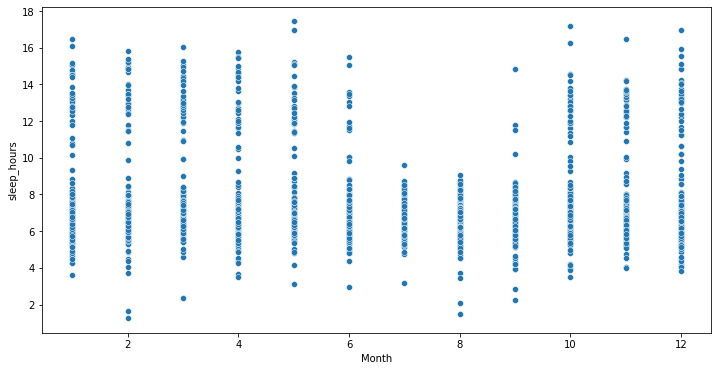

In [18]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df2, x='Month',y='sleep_hours')

<AxesSubplot:xlabel='Month', ylabel='sleep_hours'>

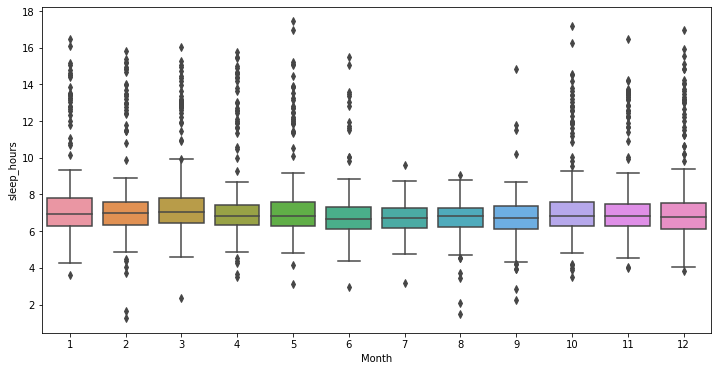

In [19]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df2, x='Month',y='sleep_hours')

<AxesSubplot:xlabel='dow', ylabel='sleep_hours'>

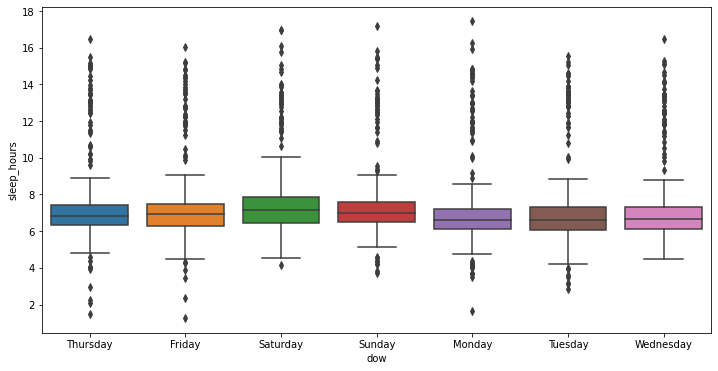

In [20]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df2, x='dow',y='sleep_hours')

<AxesSubplot:xlabel='Year', ylabel='sleep_hours'>

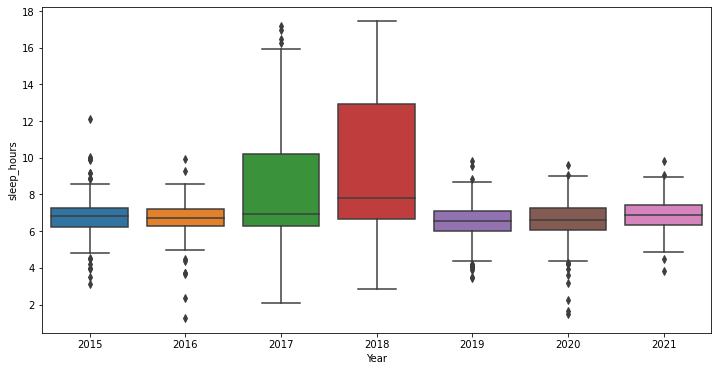

In [21]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df2, x='Year',y='sleep_hours')

<AxesSubplot:xlabel='Year', ylabel='sleep_hours'>

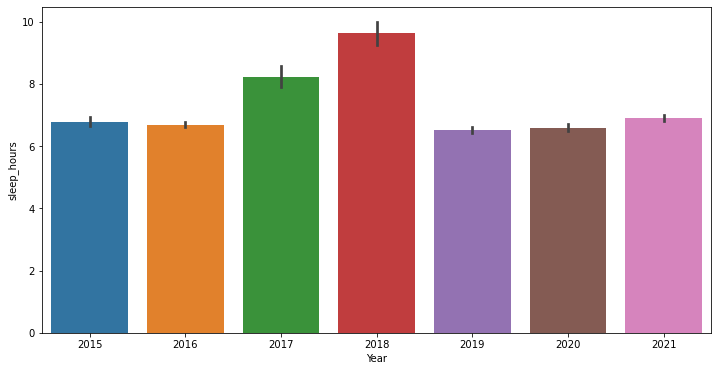

In [22]:
plt.figure(figsize=(12,6))
sns.barplot(data=df2, x='Year',y='sleep_hours')

<AxesSubplot:xlabel='Year', ylabel='sleep_hours'>

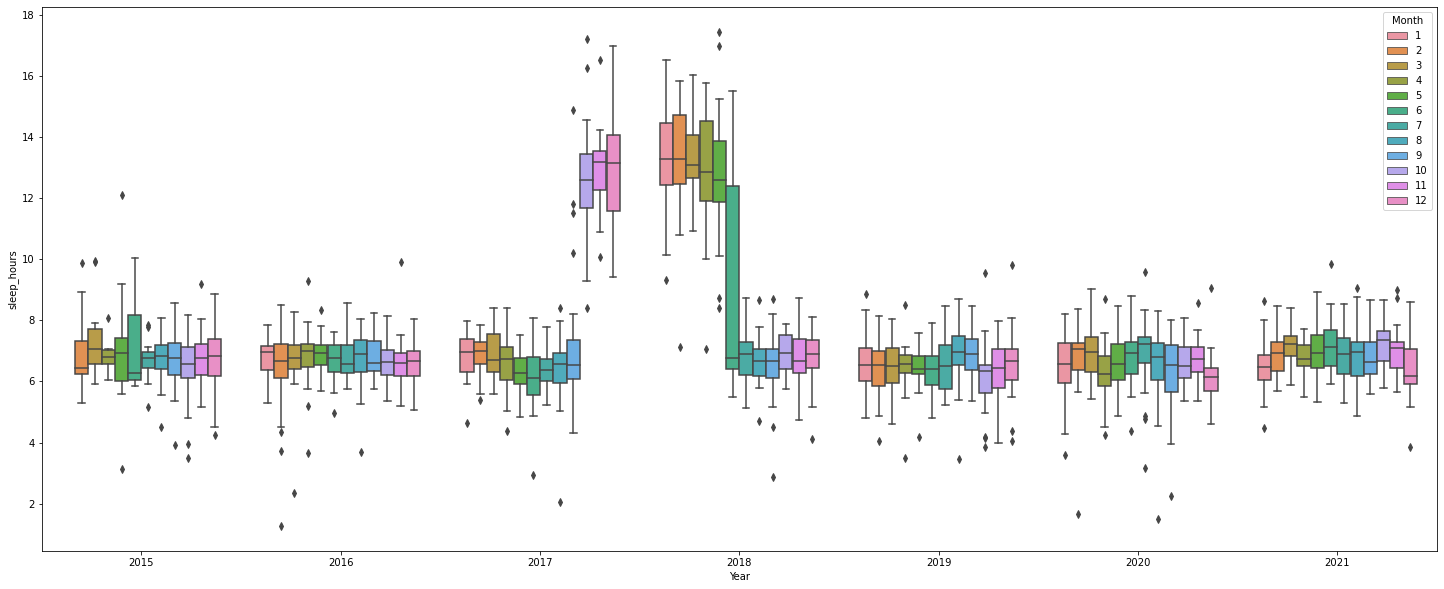

In [226]:
plt.figure(figsize=(25,10))
sns.boxplot(data=df2, x='Year',y='sleep_hours',hue='Month')

<AxesSubplot:xlabel='Month', ylabel='sleep_hours'>

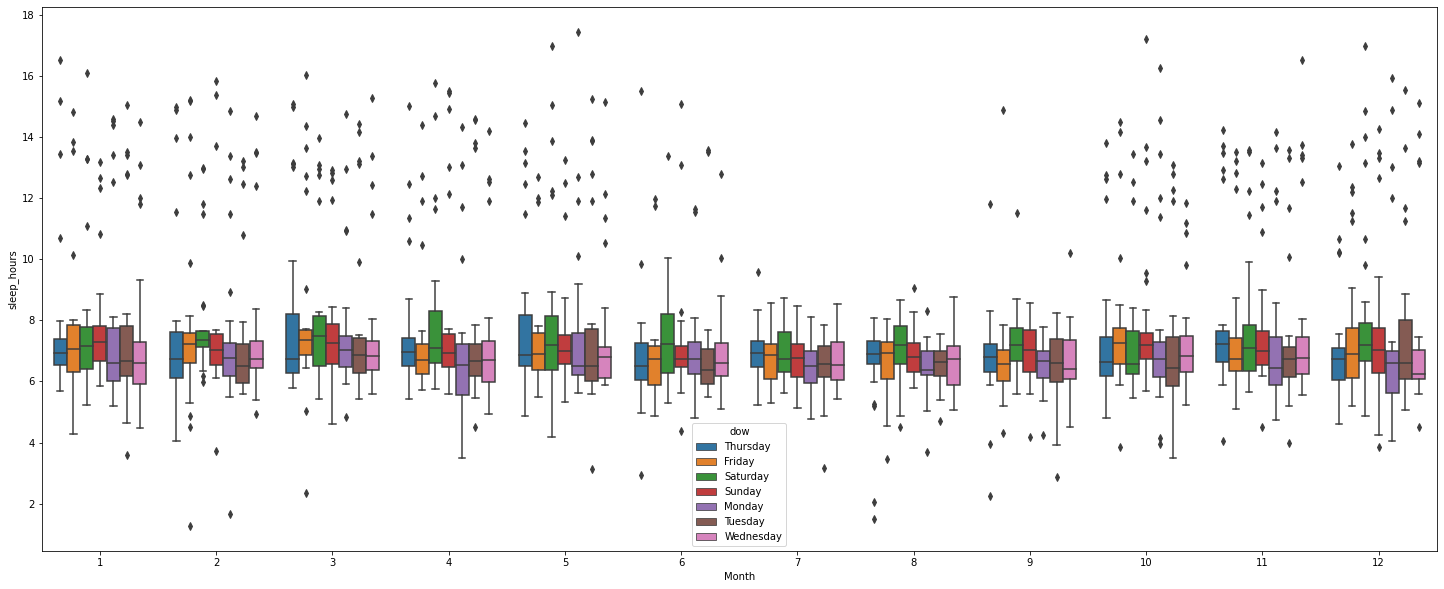

In [228]:
plt.figure(figsize=(25,10))
sns.boxplot(data=df2, x='Month',y='sleep_hours',hue='dow')

In [23]:
df3 = pd.get_dummies(df2, columns=['Month','dow'],drop_first=False).copy()

In [24]:
df3

,date,sleep_hours,Year,Day,day_imp,Month_1,Month_2,Month_3,Month_4,Month_5,...,Month_10,Month_11,Month_12,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday
0,2015-02-19,6.400000,2015,19,4,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2015-02-20,7.583333,2015,20,5,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2015-02-21,6.350000,2015,21,7,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2015-02-22,6.500000,2015,22,6,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2015-02-23,8.916667,2015,23,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2021-12-25,7.933333,2021,25,7,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
2350,2021-12-26,3.850000,2021,26,6,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2351,2021-12-29,6.175000,2021,29,3,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2352,2021-12-30,5.158333,2021,30,4,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [25]:
df3['Month'] = df2['Month']

In [26]:
df3

,date,sleep_hours,Year,Day,day_imp,Month_1,Month_2,Month_3,Month_4,Month_5,...,Month_11,Month_12,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday,Month
0,2015-02-19,6.400000,2015,19,4,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,2
1,2015-02-20,7.583333,2015,20,5,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,2
2,2015-02-21,6.350000,2015,21,7,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,2
3,2015-02-22,6.500000,2015,22,6,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,2
4,2015-02-23,8.916667,2015,23,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2021-12-25,7.933333,2021,25,7,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,12
2350,2021-12-26,3.850000,2021,26,6,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,12
2351,2021-12-29,6.175000,2021,29,3,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,12
2352,2021-12-30,5.158333,2021,30,4,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,12


In [27]:
test2 = pd.get_dummies(test, columns=['Month','dow'],drop_first=False).copy()

In [28]:
test2

,date,Year,Day,day_imp,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,...,Month_10,Month_11,Month_12,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday
0,2022-01-01,2022,1,7,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2022-01-02,2022,2,6,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2022-01-03,2022,3,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2022-01-04,2022,4,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2022-01-05,2022,5,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,2023-03-12,2023,12,6,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
415,2023-03-13,2023,13,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
416,2023-03-14,2023,14,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
417,2023-03-15,2023,15,3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [29]:
test2['Month'] = test['Month']

In [30]:
test2

,date,Year,Day,day_imp,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,...,Month_11,Month_12,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday,Month
0,2022-01-01,2022,1,7,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,2022-01-02,2022,2,6,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,2022-01-03,2022,3,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,2022-01-04,2022,4,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,2022-01-05,2022,5,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,2023-03-12,2023,12,6,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,3
415,2023-03-13,2023,13,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,3
416,2023-03-14,2023,14,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,3
417,2023-03-15,2023,15,3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,3


In [31]:
df3.columns

Index(['date', 'sleep_hours', 'Year', 'Day', 'day_imp', 'Month_1', 'Month_2',
       'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8',
       'Month_9', 'Month_10', 'Month_11', 'Month_12', 'dow_Friday',
       'dow_Monday', 'dow_Saturday', 'dow_Sunday', 'dow_Thursday',
       'dow_Tuesday', 'dow_Wednesday', 'Month'],
      dtype='object')

In [32]:
test2.columns 

Index(['date', 'Year', 'Day', 'day_imp', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
       'Month_10', 'Month_11', 'Month_12', 'dow_Friday', 'dow_Monday',
       'dow_Saturday', 'dow_Sunday', 'dow_Thursday', 'dow_Tuesday',
       'dow_Wednesday', 'Month'],
      dtype='object')

In [33]:
for i in df3.columns:
    if i not in test2.columns:
        print(i)

sleep_hours


In [34]:
for i in test2.columns:
    if i not in df3.columns:
        print(i)

In [35]:
df3.groupby('Month').median()['sleep_hours'].sort_values(ascending=True)

Month
6     6.666667
7     6.716667
9     6.716667
12    6.766667
8     6.800000
4     6.816667
10    6.816667
5     6.833333
11    6.850000
1     6.958333
2     6.983333
3     7.029167
Name: sleep_hours, dtype: float64

In [36]:
df3['Month_imp'] = df3['Month'].map({6:1, 7:2, 9:3, 12:4, 8:5, 4:6, 10:7, 5:8, 11:9, 1:10, 2:11, 3:12})

In [37]:
df3

,date,sleep_hours,Year,Day,day_imp,Month_1,Month_2,Month_3,Month_4,Month_5,...,Month_12,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday,Month,Month_imp
0,2015-02-19,6.400000,2015,19,4,0,1,0,0,0,...,0,0,0,0,0,1,0,0,2,11
1,2015-02-20,7.583333,2015,20,5,0,1,0,0,0,...,0,1,0,0,0,0,0,0,2,11
2,2015-02-21,6.350000,2015,21,7,0,1,0,0,0,...,0,0,0,1,0,0,0,0,2,11
3,2015-02-22,6.500000,2015,22,6,0,1,0,0,0,...,0,0,0,0,1,0,0,0,2,11
4,2015-02-23,8.916667,2015,23,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,2,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2021-12-25,7.933333,2021,25,7,0,0,0,0,0,...,1,0,0,1,0,0,0,0,12,4
2350,2021-12-26,3.850000,2021,26,6,0,0,0,0,0,...,1,0,0,0,1,0,0,0,12,4
2351,2021-12-29,6.175000,2021,29,3,0,0,0,0,0,...,1,0,0,0,0,0,0,1,12,4
2352,2021-12-30,5.158333,2021,30,4,0,0,0,0,0,...,1,0,0,0,0,1,0,0,12,4


In [38]:
test2['Month_imp'] = test2['Month'].map({6:1, 7:2, 9:3, 12:4, 8:5, 4:6, 10:7, 5:8, 11:9, 1:10, 2:11, 3:12})

In [39]:
test2

,date,Year,Day,day_imp,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,...,Month_12,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday,Month,Month_imp
0,2022-01-01,2022,1,7,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,10
1,2022-01-02,2022,2,6,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,10
2,2022-01-03,2022,3,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,10
3,2022-01-04,2022,4,2,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,10
4,2022-01-05,2022,5,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,2023-03-12,2023,12,6,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,3,12
415,2023-03-13,2023,13,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,3,12
416,2023-03-14,2023,14,2,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,3,12
417,2023-03-15,2023,15,3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,3,12


In [40]:
df4 = df3.drop('date',axis=1).copy()

In [41]:
test3 = test2.drop('date',axis=1).copy()

In [42]:
#df3.to_csv('train_preprocessed_2.csv',index=False)
#test2.to_csv('test_preprocessed_2.csv',index=False)

In [43]:
df4.corr()['sleep_hours'][1:].sort_values(ascending=False)

Month_imp        0.152044
day_imp          0.072985
Month_3          0.070138
dow_Saturday     0.055854
Month_1          0.053162
Month_2          0.044154
Month_4          0.037027
Month_5          0.036210
Month_11         0.032482
dow_Sunday       0.026556
Month_12         0.020493
Month_10         0.017534
dow_Thursday     0.007301
dow_Friday       0.001257
Day             -0.014685
dow_Wednesday   -0.022398
dow_Tuesday     -0.032569
dow_Monday      -0.035885
Month_6         -0.037670
Month           -0.073311
Year            -0.078989
Month_9         -0.080988
Month_7         -0.089020
Month_8         -0.095439
Name: sleep_hours, dtype: float64

<AxesSubplot:>

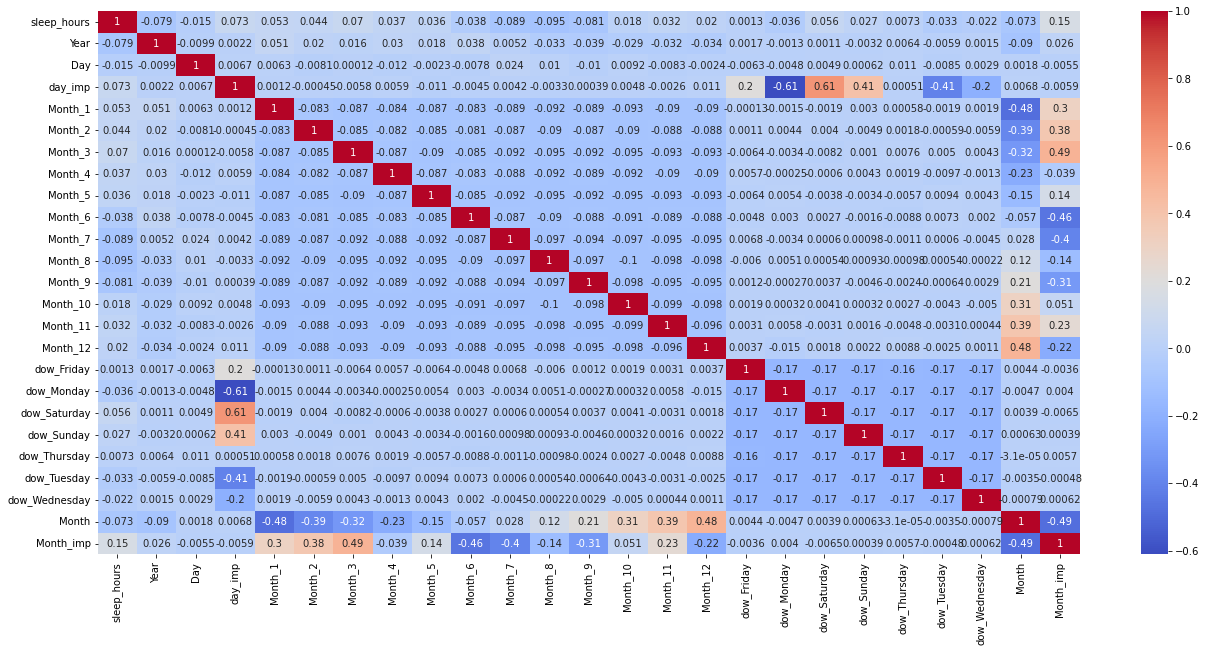

In [44]:
plt.figure(figsize=(22,10))
sns.heatmap(data=df4.corr(), annot=True, cmap='coolwarm')

In [109]:
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_validate, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

In [46]:
X = df4.drop('sleep_hours',axis=1)
y = df4['sleep_hours']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [48]:
X_train

,Year,Day,day_imp,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,...,Month_12,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday,Month,Month_imp
1135,2018,31,2,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,7,2
37,2015,15,5,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,5,8
123,2015,2,5,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,10,7
2046,2021,19,5,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2,11
394,2016,3,6,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,2019,30,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,12,4
1095,2018,21,4,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,6,1
1130,2018,26,4,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,7,2
1294,2019,15,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,10


In [49]:
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 30,  # in seconds
    "metric": 'mse',
    "task": 'regression',
    "verbose":False
}

In [50]:
automl.fit(X_train,y_train, X_val=X_test, y_val=y_test, eval_method='auto',**automl_settings)

In [51]:
automl.best_estimator

'extra_tree'

In [52]:
automl.best_config_per_estimator

{'lgbm': {'n_estimators': 28,
  'num_leaves': 31,
  'min_child_samples': 7,
  'learning_rate': 0.1400468994301556,
  'log_max_bin': 10,
  'colsample_bytree': 0.9159235947614908,
  'reg_alpha': 0.0009765625,
  'reg_lambda': 3.136860108634179},
 'rf': {'n_estimators': 4, 'max_features': 1.0, 'max_leaves': 18},
 'catboost': {'early_stopping_rounds': 10,
  'learning_rate': 0.09999999999999996,
  'n_estimators': 58},
 'xgboost': {'n_estimators': 14,
  'max_leaves': 15,
  'min_child_weight': 4.044027123585653,
  'learning_rate': 0.5800138684957256,
  'subsample': 0.8411893767107816,
  'colsample_bylevel': 0.8833142421826156,
  'colsample_bytree': 0.9423882066359944,
  'reg_alpha': 0.0009765625,
  'reg_lambda': 0.37110694019288987},
 'extra_tree': {'n_estimators': 9,
  'max_features': 0.7754448469593762,
  'max_leaves': 48},
 'xgb_limitdepth': {'n_estimators': 10,
  'max_depth': 7,
  'min_child_weight': 1.4414106781003007,
  'learning_rate': 0.36537736318193215,
  'subsample': 1.0,
  'colsamp

In [53]:
automl.best_loss_per_estimator

{'lgbm': 1.0895560456488842,
 'rf': 1.0552341887146826,
 'catboost': 1.1698171676390308,
 'xgboost': 1.138013338639672,
 'extra_tree': 1.0544112275632282,
 'xgb_limitdepth': 1.195266738243859}

In [54]:
automl_preds = automl.predict(X_test)

In [55]:
print(mean_squared_error(y_test,automl_preds)**0.5)
print(r2_score(y_test,automl_preds))

1.0268452792720177
0.7813208097238212


In [56]:
X_test.shape

(777, 24)

In [57]:
test3.shape

(419, 24)

In [58]:
sub = pd.read_csv('sample_submission.csv')

In [59]:
sub['sleep_hours'] = automl.predict(test3)

In [60]:
sub['sleep_hours'].describe()

count    419.000000
mean       6.840032
std        0.116066
min        6.667663
25%        6.740029
50%        6.811401
75%        6.868848
max        7.182745
Name: sleep_hours, dtype: float64

<AxesSubplot:>

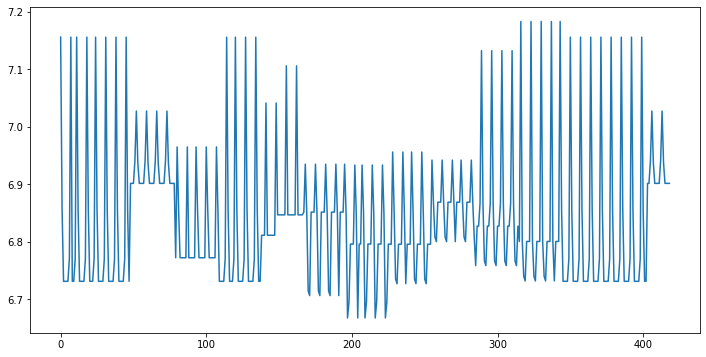

In [61]:
sub['sleep_hours'].plot(figsize=(12,6))

In [62]:
#sub.to_csv('automl_ps4_2_extratree.csv',index=False)

In [63]:
automl2 = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 300,  # in seconds
    "metric": 'mse',
    "task": 'regression',
    "verbose":False
}

In [64]:
automl.fit(X,y, eval_method='auto',**automl_settings)

In [65]:
automl.best_estimator

'rf'

In [66]:
automl.best_config_per_estimator

{'lgbm': {'n_estimators': 50,
  'num_leaves': 21,
  'min_child_samples': 14,
  'learning_rate': 0.07966958591672316,
  'log_max_bin': 10,
  'colsample_bytree': 0.8048115604863084,
  'reg_alpha': 0.002706464780236236,
  'reg_lambda': 0.4856275456621351},
 'rf': {'n_estimators': 466, 'max_features': 1.0, 'max_leaves': 25},
 'catboost': {'early_stopping_rounds': 12,
  'learning_rate': 0.1604199347807429,
  'n_estimators': 31},
 'xgboost': {'n_estimators': 4,
  'max_leaves': 13,
  'min_child_weight': 3.35911086209591,
  'learning_rate': 1.0,
  'subsample': 1.0,
  'colsample_bylevel': 1.0,
  'colsample_bytree': 1.0,
  'reg_alpha': 0.5026198937533747,
  'reg_lambda': 0.04177029135571178},
 'extra_tree': {'n_estimators': 7,
  'max_features': 0.8847394164112252,
  'max_leaves': 21},
 'xgb_limitdepth': {'n_estimators': 26,
  'max_depth': 7,
  'min_child_weight': 4.340045244379339,
  'learning_rate': 0.225733498826258,
  'subsample': 1.0,
  'colsample_bylevel': 1.0,
  'colsample_bytree': 0.99609

In [67]:
automl.best_loss_per_estimator

{'lgbm': 1.1893679757340472,
 'rf': 1.1349765799546048,
 'catboost': 1.2251197376047205,
 'xgboost': 1.173812358610533,
 'extra_tree': 1.1569379963754822,
 'xgb_limitdepth': 1.2113809767013488}

In [68]:
#automl_preds = automl.predict(X_test)

In [69]:
print(mean_squared_error(y_test,automl_preds)**0.5)
print(r2_score(y_test,automl_preds))

1.0268452792720177
0.7813208097238212


In [70]:
X_test.shape

(777, 24)

In [71]:
test3.shape

(419, 24)

In [72]:
sub = pd.read_csv('sample_submission.csv')

In [73]:
sub['sleep_hours'] = automl.predict(test3)

In [74]:
sub['sleep_hours'].describe()

count    419.000000
mean       6.862548
std        0.056826
min        6.722995
25%        6.805779
50%        6.884704
75%        6.912516
max        6.964763
Name: sleep_hours, dtype: float64

<AxesSubplot:>

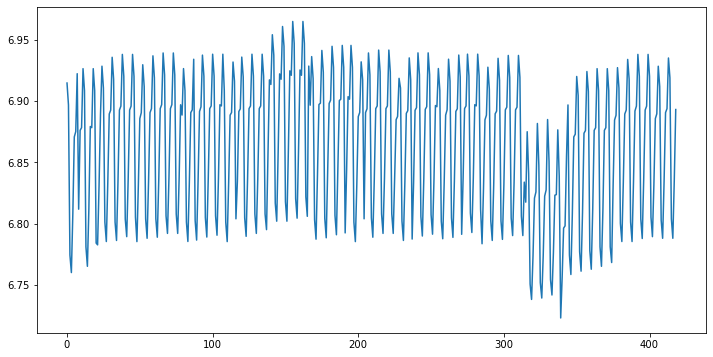

In [75]:
sub['sleep_hours'].plot(figsize=(12,6))

In [76]:
#sub.to_csv('automl_ps4_3_full_rf.csv',index=False)

## SEEMS LIKE TREE BASED MODELS ARE NOT WORKING PROPERLY
### LET'S TRY LIN_REG, LASSO_REG, ELASTIC NET, LDA, SVM, KNN, 

In [77]:
X_train

,Year,Day,day_imp,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,...,Month_12,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday,Month,Month_imp
1135,2018,31,2,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,7,2
37,2015,15,5,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,5,8
123,2015,2,5,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,10,7
2046,2021,19,5,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2,11
394,2016,3,6,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,2019,30,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,12,4
1095,2018,21,4,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,6,1
1130,2018,26,4,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,7,2
1294,2019,15,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,10


In [78]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [89]:
sc = StandardScaler()
mm = MinMaxScaler()

In [90]:
sc1 = StandardScaler()
X_train_sc = sc1.fit_transform(X_train)
X_test_sc = sc1.transform(X_test)

mm1 = MinMaxScaler()
X_train_mm = mm1.fit_transform(X_train)
X_test_mm = mm1.transform(X_test)

In [91]:
sc2 = StandardScaler()
X_sc = sc2.fit_transform(X)
test3_sc = sc2.transform(test3)

mm2 = MinMaxScaler()
X_mm = mm2.fit_transform(X)
test3_mm = mm2.transform(test3)

In [92]:
from sklearn.feature_selection import mutual_info_regression
# determine the mutual information
mutual_info = mutual_info_regression(X, y)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

Year             0.079663
dow_Saturday     0.018503
day_imp          0.017948
Month_9          0.015961
dow_Sunday       0.011006
Day              0.009887
Month_imp        0.009409
Month            0.007424
dow_Tuesday      0.006858
Month_11         0.006573
Month_12         0.005701
dow_Friday       0.005517
Month_8          0.005085
Month_7          0.000449
Month_1          0.000000
dow_Wednesday    0.000000
dow_Thursday     0.000000
Month_5          0.000000
Month_2          0.000000
dow_Monday       0.000000
Month_6          0.000000
Month_3          0.000000
Month_4          0.000000
Month_10         0.000000
dtype: float64

In [93]:
mutual_info[mutual_info>0].index

Index(['Year', 'Day', 'day_imp', 'Month_7', 'Month_8', 'Month_9', 'Month_11',
       'Month_12', 'dow_Friday', 'dow_Saturday', 'dow_Sunday', 'dow_Tuesday',
       'Month', 'Month_imp'],
      dtype='object')

In [94]:
X_mig = X[mutual_info[mutual_info>0].index]
X_train_mig = X_train[mutual_info[mutual_info>0].index]
X_test_mig = X_test[mutual_info[mutual_info>0].index]

In [95]:
sc3 = StandardScaler()
X_train_mig_sc = sc3.fit_transform(X_train_mig)
X_test_mig_sc = sc3.transform(X_test_mig)

In [96]:
mm3 = MinMaxScaler()
X_train_mig_mm = mm3.fit_transform(X_train_mig)
X_test_mig_mm = mm3.transform(X_test_mig)

In [97]:
sc4 = StandardScaler()
mm4 = MinMaxScaler()
X_mig_sc = sc4.fit_transform(X_mig)
X_mig_mm = mm4.fit_transform(X_mig)

In [98]:
test3_mig = test3[mutual_info[mutual_info>0].index]
test3_mig_sc = sc4.transform(test3_mig)
test3_mig_mm = mm4.transform(test3_mig)

## 1) KNN

In [99]:
from sklearn.neighbors import KNeighborsRegressor

In [100]:
k_loop=[]
knn_rmse_loop = []
for i in range(1,101):
    k_loop.append(i)
    knn_loop = KNeighborsRegressor(n_neighbors=i).fit(X_train_mig_mm,y_train)
    knn_loop_pred = knn_loop.predict(X_test_mig_mm)
    knn_rmse_loop.append(mean_squared_error(y_test,knn_loop_pred)**0.5)

knn_df = pd.DataFrame({'K':k_loop,'RMSE':knn_rmse_loop})
knn_df[knn_df['RMSE']==knn_df['RMSE'].min()]

,K,RMSE
2,3,1.988028


In [101]:
knn = KNeighborsRegressor(n_neighbors=6)

In [102]:
knn_cv = cross_validate(knn,X_mig_mm,y,scoring='r2',cv=RepeatedKFold(n_splits=5,n_repeats=10,random_state=42))

In [103]:
knn_cv['score_time'].mean()

0.011571626663208007

## Now we'll try linear models, like Lasso for feature selection and prediction

In [131]:
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, ElasticNet

In [126]:
lasso = Lasso(alpha=0.0001,random_state=42, max_iter=10000000)
lasso.fit(X_train_sc,y_train)
lasso_pred = lasso.predict(X_test_sc)
print(mean_squared_error(y_test,lasso_pred)**0.5)
print(r2_score(y_test,lasso_pred))

2.1596331034219287
0.03270846526042204


In [128]:
lasso.

'cyclic'

In [134]:
enet = ElasticNet(alpha=0.0001,random_state=42,).fit(X_train_sc,y_train)
enet_pred = enet.predict(X_test_sc)
print(mean_squared_error(y_test,enet_pred)**0.5)
print(r2_score(y_test,enet_pred))

2.1596432219808865
0.032699401110277804


## 3) Catboost

In [154]:
from catboost import CatBoostRegressor

In [222]:
cb = CatBoostRegressor(learning_rate=0.001, iterations=10000, random_state=42,feature_border_type='GreedyLogSum', leaf_estimation_method='Newton', bootstrap_type='Bayesian',
                      random_strength=3.9118574582633683e-07, bagging_temperature=1.0962390428013222, od_type='IncToDec',  early_stopping_rounds=30)

In [223]:
cb.fit(X_train,y_train,eval_set=(X_test,y_test),use_best_model=True,verbose=False)

In [224]:
cb.best_score_

{'learn': {'RMSE': 0.9526751638339185},
 'validation': {'RMSE': 1.051041991157555}}

In [221]:
cb.best_iteration_

16125

In [212]:
test3.shape

(419, 24)

In [213]:
X_test.shape

(777, 24)

In [214]:
sub = pd.read_csv('sample_submission.csv')
sub.head()

,date,sleep_hours
0,2022-01-01,1
1,2022-01-02,1
2,2022-01-03,1
3,2022-01-04,1
4,2022-01-05,1


In [215]:
sub['sleep_hours'] = cb.predict(test3)

<AxesSubplot:>

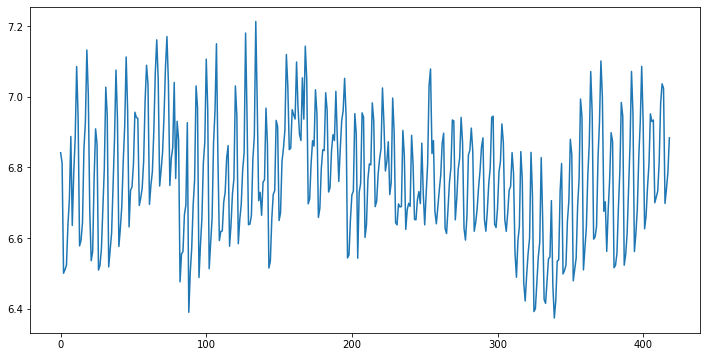

In [216]:
sub['sleep_hours'].plot(figsize=(12,6))

In [217]:
#sub.to_csv('cb_3_ps4.csv',index=False)

### It seems like a simple tree model could be the key

<AxesSubplot:xlabel='date', ylabel='sleep_hours'>

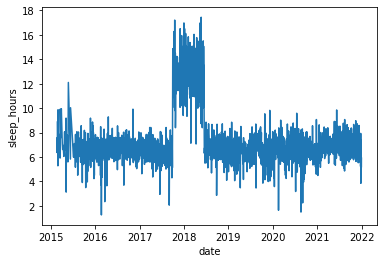

In [230]:
sns.lineplot(data=df,x='date',y='sleep_hours')

In [233]:
df[df['sleep_hours'] > df['sleep_hours'].mean() + 4*df['sleep_hours'].std()]

,date,sleep_hours,Year,Month,Day,dow,day_imp
845,2017-10-09,16.266667,2017,10,9,Monday,1
851,2017-10-15,17.200000,2017,10,15,Sunday,6
895,2017-11-29,16.500000,2017,11,29,Wednesday,3
926,2017-12-30,16.966667,2017,12,30,Saturday,7
931,2018-01-04,16.500000,2018,1,4,Thursday,4
1059,2018-05-12,16.966667,2018,5,12,Saturday,7
1068,2018-05-21,17.433333,2018,5,21,Monday,1


## Could use Sktime and AutoKeras next